<a href="https://colab.research.google.com/github/gladysadyaz/VAR/blob/main/15_Hybrid_LSTM__Wisman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import warnings
import itertools
import statsmodels.api as sm
import tensorflow.keras as keras
import seaborn as sns
import tensorflow as tf
import gc

from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.metrics import *
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from numpy import array

%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [2]:
pd.options.display.float_format = '{:.2f}'.format

# MODELING

# B. LONG SHORT TERM MEMORY

## Splitting & Scaling

In [3]:
file_path_actual = "/content/drive/My Drive/Colab Notebooks/wisman bali-kurs (1).xlsx"
df_actual = pd.read_excel(file_path_actual, sheet_name='Sheet1')
df_actual['Date'] = pd.to_datetime(df_actual['Date'], format='%d/%m/%Y')
df_actual.set_index('Date', inplace=True)
print(df_actual.head())

             Kurs  Wisman Bali  Hari Raya
Date                                     
2023-01-01  15592        10626          1
2023-01-02  15572        12338          1
2023-01-03  15590        12122          1
2023-01-04  15615        11957          1
2023-01-05  15610        13463          1


In [4]:
file_path = "/content/drive/My Drive/Colab Notebooks/varx_residuals.xlsx"
df = pd.read_excel(file_path, sheet_name='FIXVAR')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
print(df.head())

             Kurs  Wisman Bali
Date                          
2023-01-02 -19.95         1700
2023-01-03   2.17         2052
2023-01-04  22.77         2008
2023-01-05  18.88         3759
2023-01-06  43.49         3592


In [5]:
steps_slicing = 90
df_final = df_actual[:-steps_slicing]
df_update = df_actual[-steps_slicing:]

In [6]:
# Select only the 'Wisman Bali' column for input and output
df_residual = df['Wisman Bali']
data2 = df_residual.copy()
data2

,Wisman Bali
Date,
2023-01-02,1700
2023-01-03,2052
2023-01-04,2008
2023-01-05,3759
2023-01-06,3592
...,...
2025-01-16,-2399
2025-01-17,-1242
2025-01-18,-1792


In [7]:
scaler2 = MinMaxScaler()
scaled_data2 = scaler2.fit_transform(data2.values.reshape(-1, 1))

In [8]:
# Prepare the dataset for LSTM
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]  # Use only the first column
        dataX.append(a)
        dataY.append(data[i + time_step, 0])  # Use only the first column
    return np.array(dataX), np.array(dataY)

In [9]:
# Set the time step
time_step = 15

# Create the dataset for LSTM
X2, y2 = create_dataset(scaled_data2, time_step)

# Reshape X2 to be [samples, time steps, features] which is required for LSTM
X2 = X2.reshape(X2.shape[0], X2.shape[1], 1)

In [10]:
test_size2 = 90
train_size2 = len(X2) - test_size2
X2_train, X2_test = X2[:train_size2], X2[train_size2:]
y2_train, y2_test = y2[:train_size2], y2[train_size2:]

## Hypertuning Parameters

In [11]:
# Function to create model for LSTM
def create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme):
    seed_value = 54
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=(time_step, 1), kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(LSTM(units=units2, kernel_initializer=init_scheme))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='linear', kernel_initializer=init_scheme))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [12]:
# Define the hyperparameter grid for LSTM
param_grid_lstm2 = {
    'units1': [50, 100],
    'units2': [50, 100],
    'dropout_rate': [0, 0.2, 0.3],
    'learning_rate': [0.01, 0.001],
    'batch_size': [16, 32, 64],
    'epochs': [100],
    'init_scheme': ['glorot_uniform','he_uniform']
}

In [13]:
from itertools import product
# Convert param_grid to a list of dictionaries
param_list_lstm2 = list(product(param_grid_lstm2['units1'],
                                param_grid_lstm2['units2'],
                                param_grid_lstm2['dropout_rate'],
                                param_grid_lstm2['learning_rate'],
                                param_grid_lstm2['batch_size'],
                                param_grid_lstm2['epochs'],
                                param_grid_lstm2['init_scheme'],))

In [14]:
# Initialize variables to track the best model and the best score for LSTM2
best_score_lstm2 = float('inf')
best_params_lstm2 = None
best_model_lstm2 = None

# Perform manual grid search for LSTM
for params in param_list_lstm2:
    units1, units2, dropout_rate, learning_rate, batch_size, epochs, init_scheme = params

    print(f"Training LSTM model with parameters: units1={units1}, units2={units2}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")

    model_lstm2 = create_model_lstm2(units1, units2, dropout_rate, learning_rate, init_scheme)

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history_lstm2 = model_lstm2.fit(X2_train, y2_train, batch_size=batch_size, epochs=epochs, validation_data=(X2_test, y2_test), callbacks=[early_stopping], verbose=0)

    val_loss = min(history_lstm2.history['val_loss'])

    if val_loss < best_score_lstm2:
        best_score_lstm2 = val_loss
        best_params_lstm2 = {
            'units1': units1,
            'units2': units2,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'epochs': epochs,
            'init_scheme': init_scheme
        }
        best_model_lstm2 = model_lstm2

print(f"Best LSTM score: {best_score_lstm2} with parameters: {best_params_lstm2}")

Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.01, batch_size=16, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.01, batch_size=16, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.01, batch_size=32, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.01, batch_size=32, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.01, batch_size=64, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.01, batch_size=64, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.001, batch_size=16, epochs=100
Training LSTM model with parameters: units1=50, units2=50, dropout_rate=0, learning_rate=0.001, batch_size=16, epochs=100
Training LSTM model with param

## Model

In [15]:
best_params_lstm2

{'units1': 100,
 'units2': 100,
 'dropout_rate': 0.2,
 'learning_rate': 0.01,
 'batch_size': 32,
 'epochs': 100,
 'init_scheme': 'he_uniform'}

In [16]:
# Ambil parameter terbaik dari hasil grid search
manual_units1_lstm2 = best_params_lstm2['units1']
manual_units2_lstm2 = best_params_lstm2['units2']
manual_dropout_rate_lstm2 = best_params_lstm2['dropout_rate']
manual_learning_rate_lstm2 = best_params_lstm2['learning_rate']
manual_batch_size_lstm2 = best_params_lstm2['batch_size']
manual_epochs_lstm2 = best_params_lstm2['epochs']
manual_init_scheme_lstm2 = best_params_lstm2['init_scheme']

# Buat model dengan parameter terbaik
model_manual_lstm2 = create_model_lstm2(manual_units1_lstm2,
                                        manual_units2_lstm2,
                                        manual_dropout_rate_lstm2,
                                        manual_learning_rate_lstm2,
                                        manual_init_scheme_lstm2)

# Early stopping callbacks
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50,
                               restore_best_weights=True)

# Latih model dengan parameter terbaik
history_manual_lstm2 = model_manual_lstm2.fit(X2_train,
                                              y2_train,
                                              batch_size=manual_batch_size_lstm2,
                                              epochs=manual_epochs_lstm2,
                                              validation_data=(X2_test, y2_test),
                                              callbacks=[early_stopping],
                                              verbose=1)

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.9081 - val_loss: 0.1327
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0479 - val_loss: 0.0855
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0346 - val_loss: 0.0566
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0271 - val_loss: 0.0338
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195 - val_loss: 0.0080
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0170 - val_loss: 0.0056
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0125 - val_loss: 0.0047
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120 - val_loss: 0.0031
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - val_loss: 0.0029
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096 - val_loss: 0.0033
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099 - val_loss: 0.0034
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.

In [17]:
# Summary model
model_manual_lstm2.summary()

Model: "sequential_144"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_288 (LSTM)                 │ (None, 15, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_288 (Dropout)           │ (None, 15, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_289 (LSTM)                 │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_289 (Dropout)           │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 363,905 (1.39 MB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 242,604 (947.68 KB)

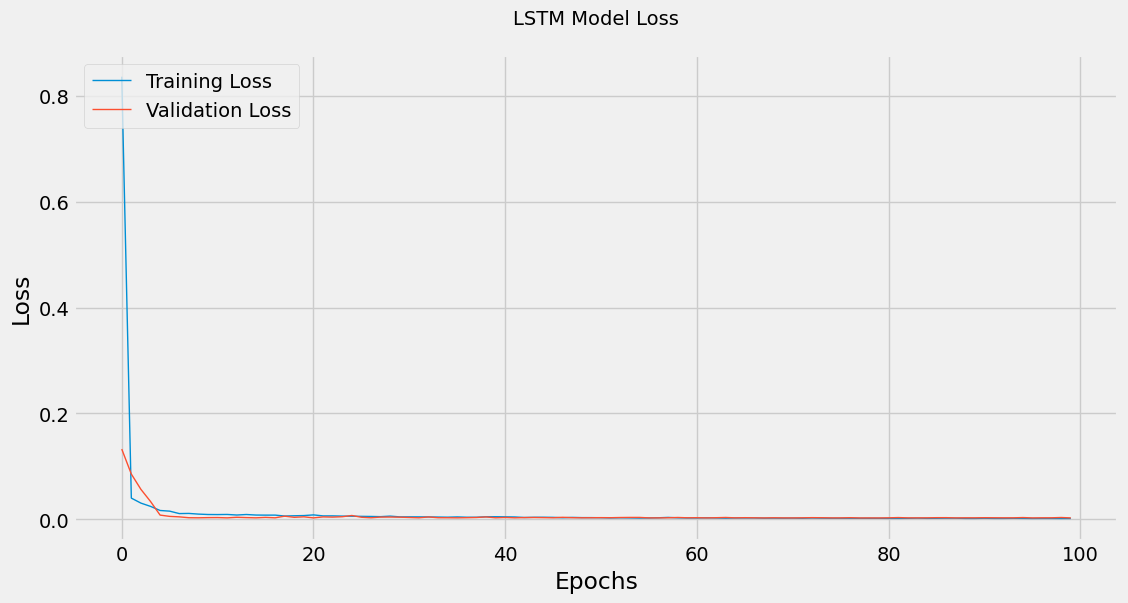

In [18]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(history_manual_lstm2.history['loss'], label='Training Loss', linewidth=1)
plt.plot(history_manual_lstm2.history['val_loss'], label='Validation Loss', linewidth=1)
plt.title('LSTM Model Loss\n', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [19]:
# Predict on the training data for LSTM
train_predict_lstm2 = model_manual_lstm2.predict(X2_train)
test_predict_lstm2 = model_manual_lstm2.predict(X2_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [20]:
# Inverse transform the predictions for LSTM
train_predict_lstm2 = scaler2.inverse_transform(train_predict_lstm2)
test_predict_lstm2 = scaler2.inverse_transform(test_predict_lstm2)
y2_train = scaler2.inverse_transform(y2_train.reshape(-1, 1))
y2_test = scaler2.inverse_transform(y2_test.reshape(-1, 1))

## Evaluation & Visualization

In [21]:
# Calculate MAPE for LSTM
train_mape_kurs_lstm2 = mean_absolute_percentage_error(y2_train, train_predict_lstm2)
test_mape_kurs_lstm2 = mean_absolute_percentage_error(y2_test, test_predict_lstm2)

print(f'Training MAPE (Wisman Bali) LSTM: {train_mape_kurs_lstm2:.4f}')
print(f'Testing MAPE (Wisman Bali) LSTM: {test_mape_kurs_lstm2:.4f}')


Training MAPE (Wisman Bali) LSTM: 0.3723
Testing MAPE (Wisman Bali) LSTM: 1.5046


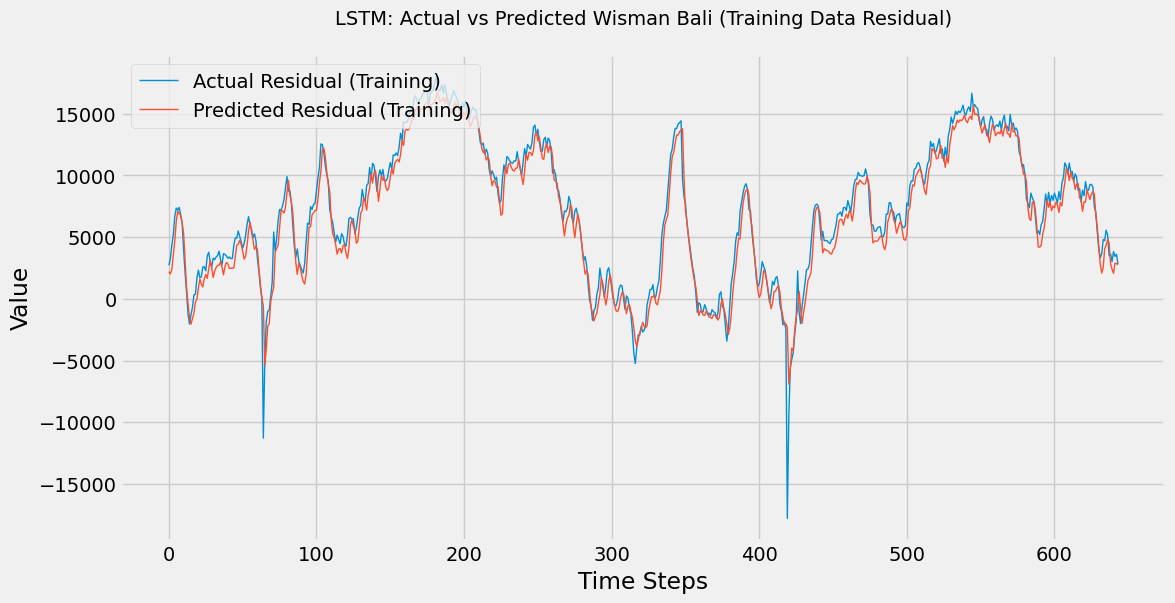

In [22]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_train, label='Actual Residual (Training)', linewidth=1)
plt.plot(train_predict_lstm2, label='Predicted Residual (Training)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Wisman Bali (Training Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

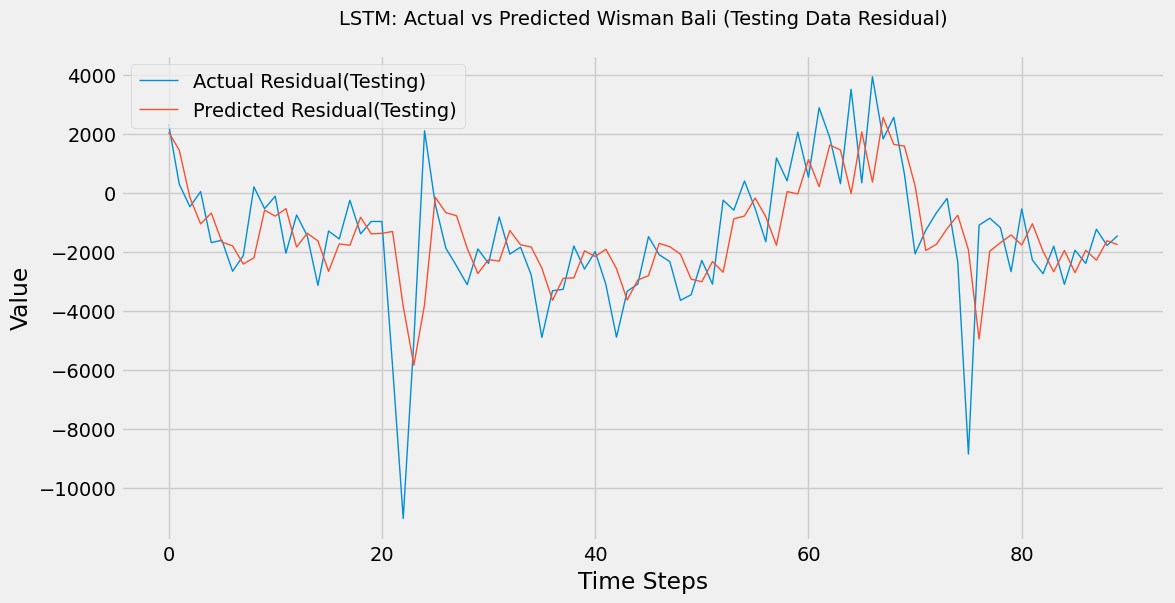

In [23]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(y2_test, label='Actual Residual(Testing)', linewidth=1)
plt.plot(test_predict_lstm2, label='Predicted Residual(Testing)', linewidth=1)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('LSTM: Actual vs Predicted Wisman Bali (Testing Data Residual)\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Forecasting



In [24]:
# Forecasting for the next 90 steps
predictions_lstm2 = []
input_data_lstm2 = scaled_data2[-time_step:].reshape(1, time_step, 1)

for _ in range(90):
    pred = model_manual_lstm2.predict(input_data_lstm2)
    predictions_lstm2.append(pred[0])
    input_data_lstm2 = np.append(input_data_lstm2[:, 1:, :], [[pred[0]]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [25]:
# Inverse transform the predictions to original scale
predictions_lstm2 = scaler2.inverse_transform(predictions_lstm2)

# Save predictions to DataFrame
df_future_predictions_lstm2 = pd.DataFrame(predictions_lstm2, columns=['Predicted Residual Wisman Bali'])

# Assuming df_update is the dataframe where you want to align future predictions, here aligning index with the valid_data's last 7 steps.
df_future_predictions_lstm2.index = df_update.index

# Display the future predictions DataFrame
df_future_predictions_lstm2

,Predicted Residual Wisman Bali
Date,
2024-10-23,-2127.03
2024-10-24,-2190.83
2024-10-25,-2163.89
2024-10-26,-2190.66
2024-10-27,-2149.21
...,...
2025-01-16,-2107.57
2025-01-17,-2107.57
2025-01-18,-2107.57


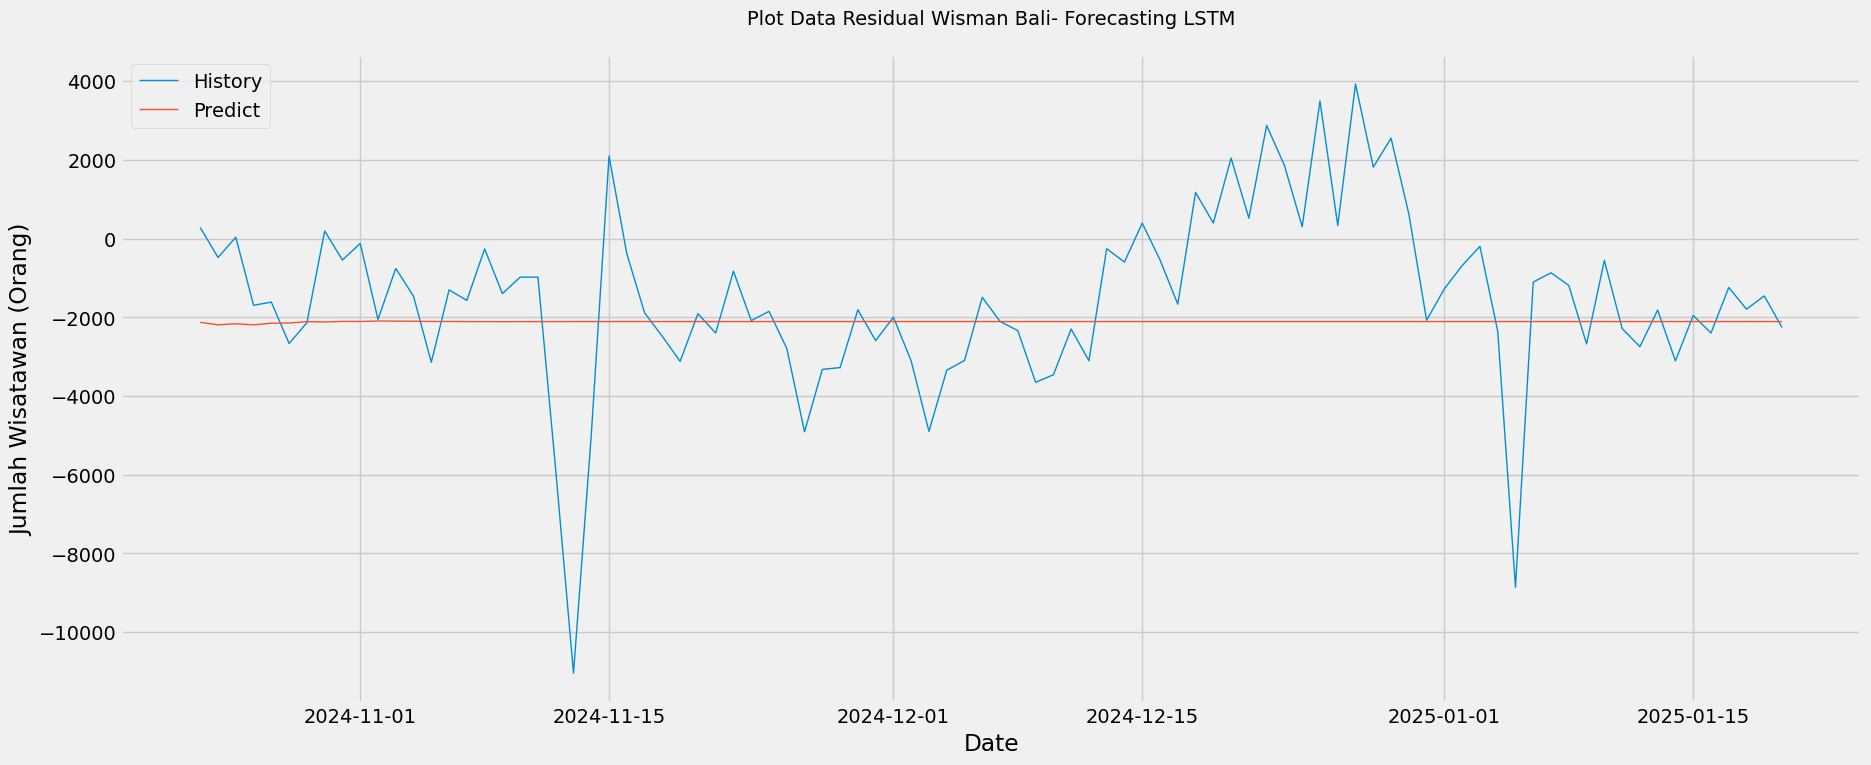

In [26]:
# Plot Data
plt.figure(figsize=(20, 8))
plt.plot(df.iloc[-90:]['Wisman Bali'], linewidth=1, label='History')
plt.plot(df_future_predictions_lstm2['Predicted Residual Wisman Bali'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Jumlah Wisatawan (Orang)')
plt.title('Plot Data Residual Wisman Bali- Forecasting LSTM\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# C. HYBRID VARX-LSTM

## Model

In [27]:
file_path_forecast = "/content/drive/My Drive/Colab Notebooks/varx_forecast.xlsx"
df_forecast = pd.read_excel(file_path_forecast, sheet_name='FIXVAR')
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'], format='%d/%m/%Y')
df_forecast.set_index('Date', inplace=True)
print(df_forecast.head())

               Kurs  Wisman Bali
Date                            
2024-10-23 15563.19        19031
2024-10-24 15556.90        19251
2024-10-25 15558.64        20218
2024-10-26 15557.91        19982
2024-10-27 15553.73        20022


In [28]:
df_linear = df_forecast[['Wisman Bali']]
df_linear

,Wisman Bali
Date,
2024-10-23,19031
2024-10-24,19251
2024-10-25,20218
2024-10-26,19982
2024-10-27,20022
...,...
2025-01-16,20420
2025-01-17,20432
2025-01-18,20444


In [29]:
df_nonlinear = df_future_predictions_lstm2.copy()
df_nonlinear

,Predicted Residual Wisman Bali
Date,
2024-10-23,-2127.03
2024-10-24,-2190.83
2024-10-25,-2163.89
2024-10-26,-2190.66
2024-10-27,-2149.21
...,...
2025-01-16,-2107.57
2025-01-17,-2107.57
2025-01-18,-2107.57


In [30]:
df_hybrid = pd.DataFrame({
    'Hybrid Wisman Bali': df_linear['Wisman Bali'] + df_nonlinear['Predicted Residual Wisman Bali'],
})
df_hybrid

,Hybrid Wisman Bali
Date,
2024-10-23,16903.97
2024-10-24,17060.17
2024-10-25,18054.11
2024-10-26,17791.34
2024-10-27,17872.79
...,...
2025-01-16,18312.43
2025-01-17,18324.43
2025-01-18,18336.43


In [31]:
df_hybrid_final = pd.merge(df_update['Wisman Bali'], df_hybrid, left_index=True, right_index=True)
print(df_hybrid_final.shape)
df_hybrid_final

(90, 2)


,Wisman Bali,Hybrid Wisman Bali
Date,,
2024-10-23,19314,16903.97
2024-10-24,18771,17060.17
2024-10-25,20254,18054.11
2024-10-26,18288,17791.34
2024-10-27,18408,17872.79
...,...,...
2025-01-16,18021,18312.43
2025-01-17,19190,18324.43
2025-01-18,18652,18336.43


## Evaluation & Visualization

In [32]:
# Define true and predicted 'Close' values
y_true = df_hybrid_final['Wisman Bali']
y_pred = df_hybrid_final['Hybrid Wisman Bali']

In [33]:
mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # dikali 100 agar jadi persentase
print(f"Mean Absolute Percentage Error (MAPE) for Hybrid Wisman Bali: {mape:.2f}%")

Mean Absolute Percentage Error (MAPE) for Hybrid Wisman Bali: 9.20%


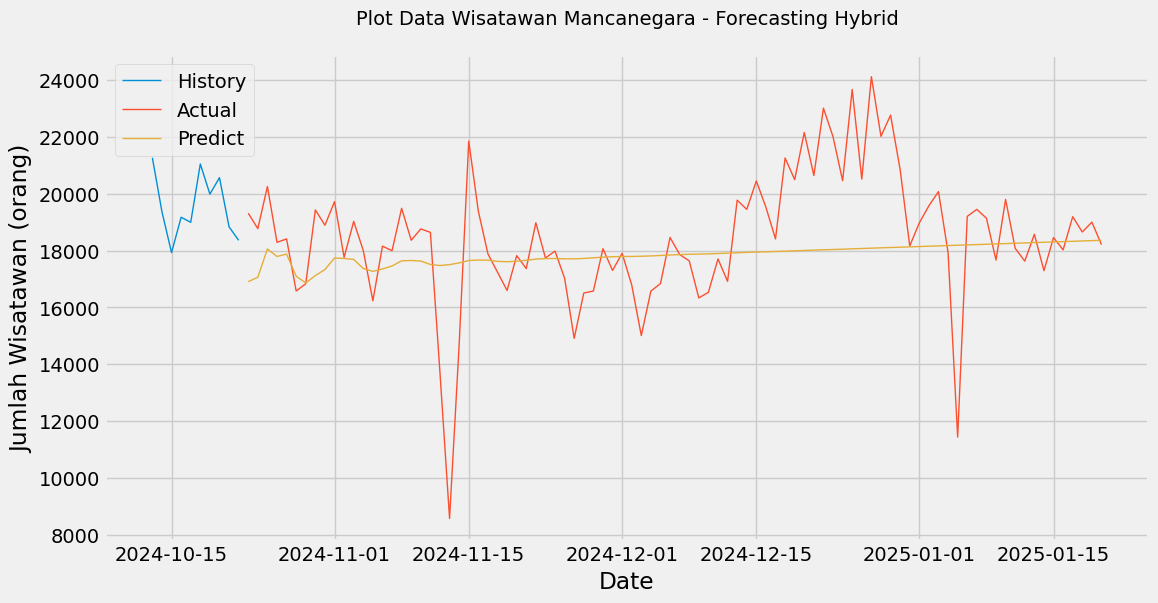

In [34]:
# Plot Data
plt.figure(figsize=(12, 6))
plt.plot(df_final.iloc[-10:]['Wisman Bali'], linewidth=1, label='History')
plt.plot(df_hybrid_final['Wisman Bali'], linewidth=1, label='Actual')
plt.plot(df_hybrid_final['Hybrid Wisman Bali'], linewidth=1, label='Predict')
plt.xlabel('Date')
plt.ylabel('Jumlah Wisatawan (orang)')
plt.title('Plot Data Wisatawan Mancanegara - Forecasting Hybrid\n', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)
plt.show()